# **EE214 Machine Learning Basics and Practices**
## **Mini-Assignment 3**

In this assignment, you should use a GPU provided by Colab. Please set the hardware accelerator to GPU. And in Colab, there is a GPU usage limit of up to 12 hours per day. So it is recommended to do this assignment in advance when you have enough time.



## **Submission guidelines**

- You should fill in all the blanks and follow **all the TODO list** in this file.

- You don't need to annotate on your code. But please write descriptions of your source code and answers to the given questions in the report. There is no limit to the format of your report.

- You should **submit both the ipynb file and the report**. **Otherwise, you can't get a full score.**

- The name of zip file should be **studentID_Name**. You can submit it through KLMS. **Submission due is 11:59 p.m. on June 17(Sat).**

- Our late submission policy is as follows:

    **0 hours ~ 3 hours: 90%**

    **3 hours ~ 6 hours: 80%**

    **6 hours ~ 12 hours: 70%**

    **12 hours ~ 24 hours: 50%**

    **24 hours ~ : 0%**

- If you have further questions, please feel free to ask via email

# **Part 1.** Implement LSTM model in word-level language modelling

## **Task** : **IMDB Movie Review Sentiment Analysis**
- This task takes a movie review (text data) as input and classifies it as 1 for positive and 0 for negative.
- To tackle this task, we will utilize the `many-to-one` RNN structure.


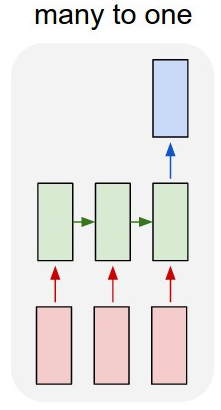

## **Preprocessing for natural language processing (NLP)**






- To put words in a sentence as input to neural network, we should preprocess the text data and convert the words in a sentence to a vector representation.

- The process for this is as follows (refer to the figures below):
    - **Step 1. Text preprocessing**
        - 1) Tokenization : Split a sentence into words
        - 2) Lowercase : Make words lowercase
        - 3) Remove punctuation : Remove punctuations (. / , ' ' ~ ?) that are not necessary for analysis
    - **Step 2. Make vocabulary and give each word a unique integer**
        - Collect the words from the training dataset and make a vocabulary book.
        - Give a unique integer to each word in the vocabulary
    - **Step 3. Word embedding**
        - Give each integer a unique vector
        - There are various methods for word embedding. It will be described later.



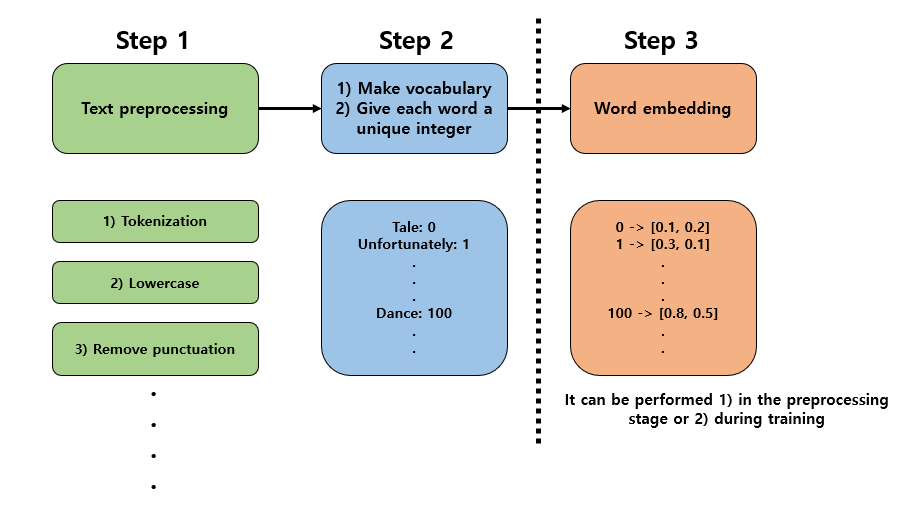

For example, each sentence is converted to corresponding vectors as follows:

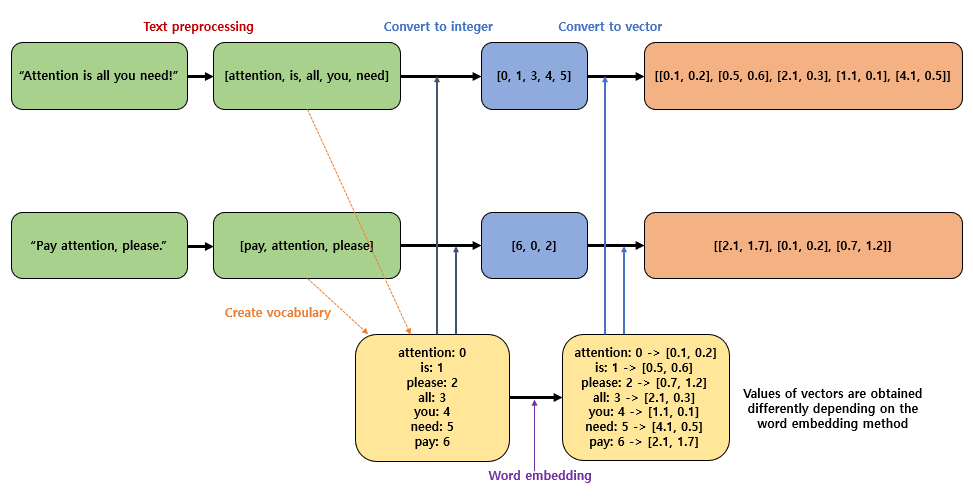

## **1. Preprocessing for natural language processing (NLP) using torchtext**

- PyTorch provides `torchtext package` that can conveniently implement deep learning with text data.


In [1]:
!pip install torch==1.13.0
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from tqdm import tqdm
import time
import urllib.request
import pandas as pd

#Set random seed for reproduction
random.seed(2023)
np.random.seed(2023)
torch.manual_seed(2023)

!pip install -U torchtext==0.6.0

#torchtext package
from torchtext import data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.

### **1) Data loading**

- First, download the `IMDB Movie Review Sentiment Analysis` dataset, which is the dataset we will use for this task.

- Each sample consists of a sentence and a label (0: negative or 1: positive)

In [2]:
#Data loading

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")
df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [3]:
#Check the dataset size

print('The total number of samples : {}'.format(len(df)))

The total number of samples : 50000


In [4]:
#Split the dataset into train and test dataset

train_df = df[:30000]
test_df = df[-20000:]

train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

### **2) Text preprocessing using Field method**

- We can preprocess text data using Field method provided by torchtext (see https://torchtext.readthedocs.io/en/latest/data.html#fields for details). But you don't have to know it in detail.

In [5]:
# Text preprocessing using Field method

TEXT = data.Field(sequential=True, # Whether the datatype represents sequential data
                  use_vocab=True, # Whether to make a Vocabulary
                  tokenize=str.split, # The function used to tokenize strings using this field into sequential examples
                  lower=True, # Whether to lowercase the text
                  batch_first=True,
                  fix_length=200)   # Note that the length of the sentences are all different.
                                    # If the length of a sentence is longer than 200, the length is reduced to 200 (remove the back part). And if it is shorter than 200, the length is made 200 by padding with 0.

LABEL = data.Field(sequential=False,
                   batch_first=False,
                   is_target=True) #

### **3) Loading datasets**

In [6]:
train_data, test_data = data.TabularDataset.splits(
        path='.', train='train_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

We can see the result of preprocessing as follows:

In [7]:
print(vars(train_data[1]))

{'text': ['believe', 'it', 'or', 'not,', 'this', 'was', 'at', 'one', 'time', 'the', 'worst', 'movie', 'i', 'had', 'ever', 'seen.', 'since', 'that', 'time,', 'i', 'have', 'seen', 'many', 'more', 'movies', 'that', 'are', 'worse', '(how', 'is', 'it', 'possible??)', 'therefore,', 'to', 'be', 'fair,', 'i', 'had', 'to', 'give', 'this', 'movie', 'a', '2', 'out', 'of', '10.', 'but', 'it', 'was', 'a', 'tough', 'call.'], 'label': '0'}


### **4) Create vocabulary**
- Create a vocabulary by collecting words from training data.

In [8]:
TEXT.build_vocab(train_data, min_freq=5) # Create vocabulary # Here, add only words that appear at least "min_freq (5)" times in the trainset to the vocabulary # Words that appear less than five times are replaced with the token <unk> in the sense of Unknown.
LABEL.build_vocab(train_data)

In [9]:
vocab_size = len(TEXT.vocab)
num_classes = 2
print('The size of vocabulary : {}'.format(vocab_size))
print('The number of classes : {}'.format(num_classes))

The size of vocabulary : 51394
The number of classes : 2


We can see the vocabulary and the unique integers assigned to each word.

In [10]:
TEXT.vocab.stoi
# torchtest assigns 0 to <unk> token and 1 to <pad> token.
# <unk> is used to represent words that is not in the vocabulary.
# <pad> is used for padding to match the fixed length.

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f785df1fee0>>,
            {'<unk>': 0,
             '<pad>': 1,
             'the': 2,
             'a': 3,
             'and': 4,
             'of': 5,
             'to': 6,
             'is': 7,
             'in': 8,
             'i': 9,
             'this': 10,
             'it': 11,
             'that': 12,
             '/><br': 13,
             'was': 14,
             'as': 15,
             'with': 16,
             'for': 17,
             'but': 18,
             'on': 19,
             'movie': 20,
             'his': 21,
             'are': 22,
             'not': 23,
             'you': 24,
             'film': 25,
             'have': 26,
             'he': 27,
             'be': 28,
             'at': 29,
             'one': 30,
             'by': 31,
             'an': 32,
             'they': 33,
             'from': 34,
             'who': 35,
             'all': 36,
             'like

### **5) Dataloader**
- TorchText supports batch processing of all data and provides a BucketIterator that replaces words with corresponding integers using the vocabulary created above.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

train_iter, test_iter = data.BucketIterator.splits(
        (train_data, test_data), batch_size=batch_size,
        shuffle=True, repeat=False)

batch = next(iter(train_iter))

We can see that each word is converted to the corresponding integer value.

In [12]:
print(batch.text)

tensor([[    9,   176,   251,  ...,     1,     1,     1],
        [    9,   217,     3,  ...,     1,     1,     1],
        [ 2624,     3,  2517,  ...,     2,   637,     4],
        ...,
        [    9,    26,    23,  ...,     9,    53,    37],
        [    9,  5219,    19,  ...,     1,     1,     1],
        [    9,  5983,     8,  ...,   253,     8, 39307]])


The shape of a batch should be [64, 200] = [batch size, fixed_length (sequence length)]

In [13]:
batch = next(iter(train_iter))
print('The shape of a batch is :', batch.text.shape)

The shape of a batch is : torch.Size([64, 200])


Divide the training dataset to get the validation set.



In [14]:
train_data, val_data = train_data.split(split_ratio=0.8)

train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (train_data, val_data, test_data), batch_size=batch_size,
        shuffle=True, repeat=False, sort=False)

## **2. Word Embedding**


- If we use the one-hot encoding method (sparse representation) for word embedding as in the previous practice session, the curse of dimensionality occurs (note that the vocab size is 51394).
- Therefore, in practice, we have to express a word as a dense vector (distributed representation) with low dimension.
- There are various methods for word embedding in NLP. Among them, we will use nn.Embedding provided by PyTorch for this task.
- nn.Embedding provides a lookup table which stores embeddings of each word.
- Therefore, each integer is converted to a corresponding vector, referring to the lookup table. The values in the lookup table are learnable parameters and are updated at the training time (see the below figure).
- **You don't need to know it in detail. Just understand that it converts each integer to the corresponding vector.**

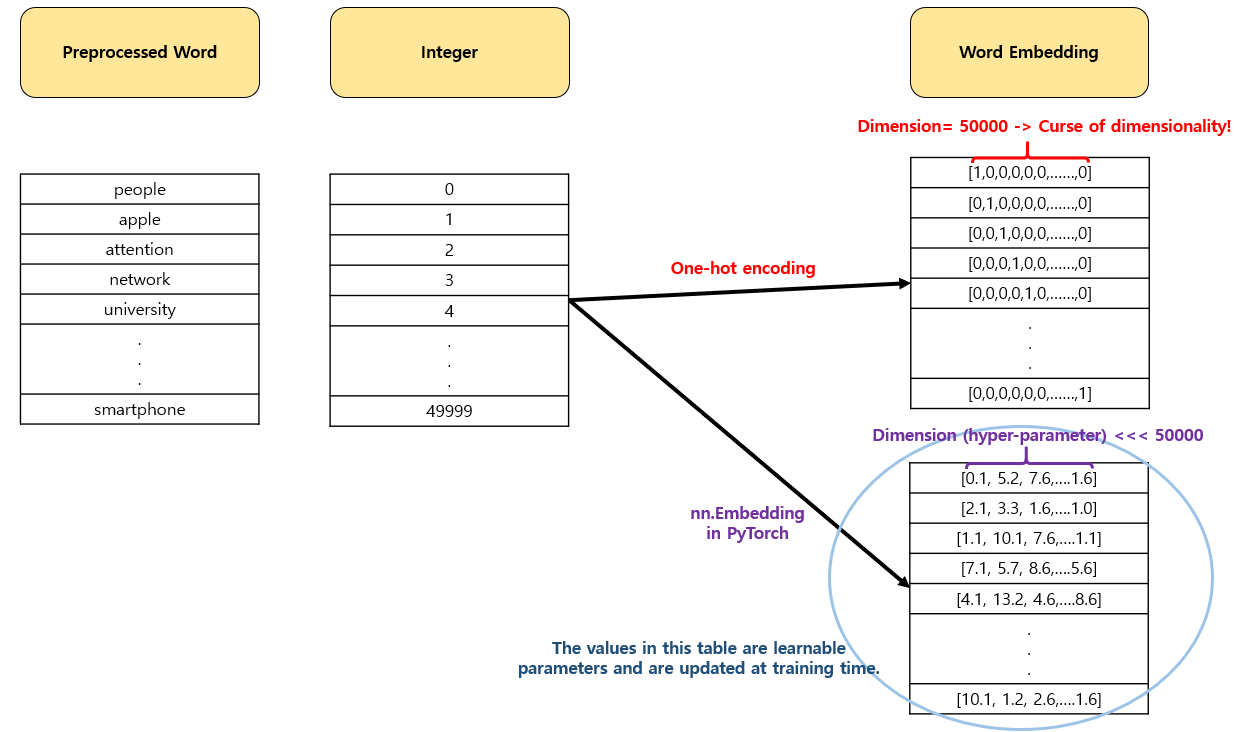

## **Task 1. Implement LSTM network and LSTMCell module**


- Finally, we understood the transformation from sentences to vector representations suitable for the input of neural network.
- Based on these concepts, let's implement LSTM network for our task (IMDB Movie Review Sentiment Analysis).

- First of all, you will implement ```LSTMCell``` which will be used in the ```MyLSTM``` module. (please refer to https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html to grasp what parameters and methods are here and how each method works)

**Hint: You can define the weights of LSTMCell by using either ```nn.Linear()``` or ```nn.Parameter()```.**

- Embedding vectors corresponding to words are sequentially entered into the LSTMCell one by one, and 'h (hidden state)' and 'c (cell state)' are iteratively changed. At the end, you should take only **the last hidden state** and pass it through the dropout layer, and finally use the fc layer to perform classification.

- Note that **batch-wise operation is performed**. It would be good to check the size of each output at each stage. (You will find this easily if you use the `pdb.set_trace()` in the `pdb` module.)

The following figure shows a single LSTM cell:

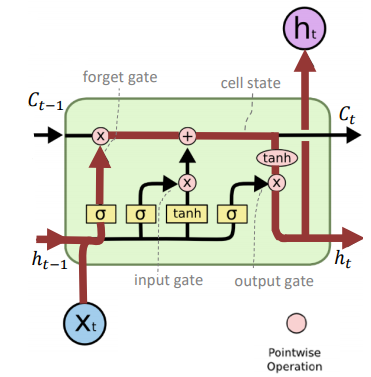

The overall process is well described in the figure below.
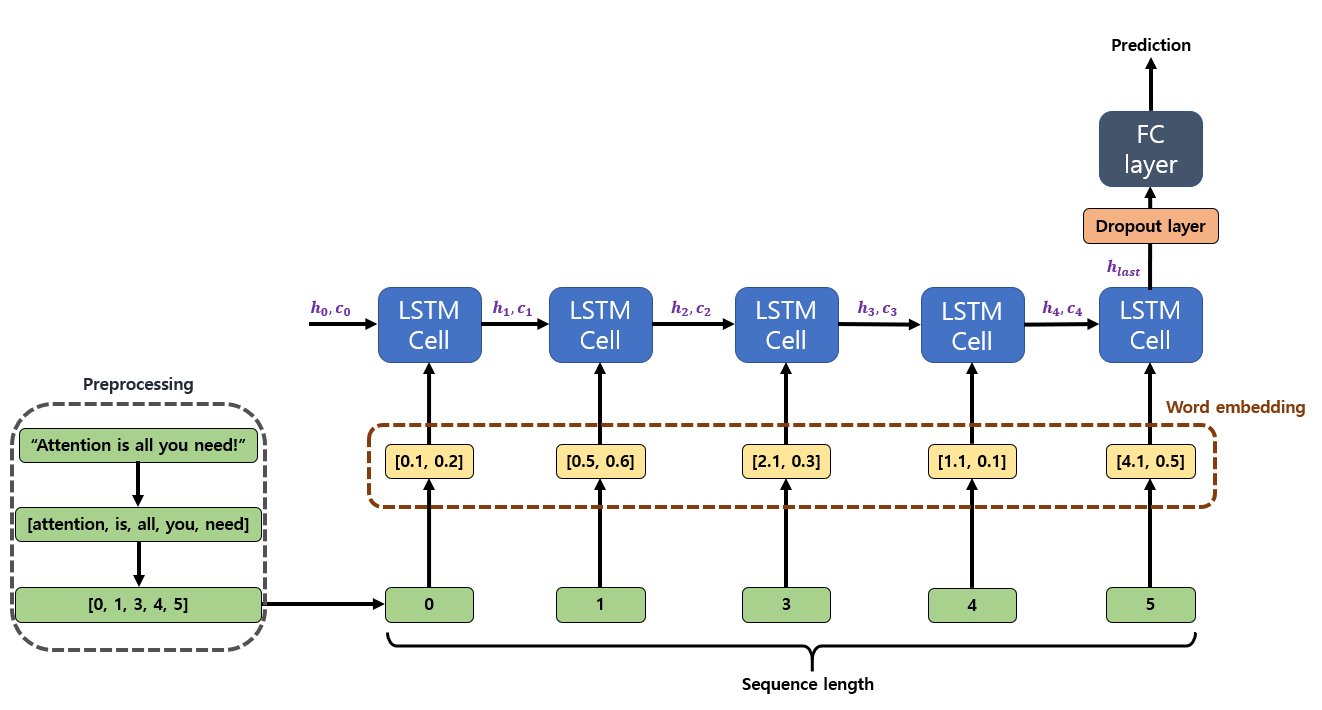

## **TODO** : Fill in the blanks of the codes to perform the above process and write your own description of the source code in your report.

In [15]:
import math

class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()
        # fill in the blank --------------------------------------

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.x2h = nn.Linear(input_size, 4*hidden_size)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size)
        # --------------------------------------------------------
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, input, hidden_states):
        # fill in the blank --------------------------------------
        h_in, c_in = hidden_states
        x = input.view(-1, input.size(1))

        gates = self.x2h(x) + self.h2h(h_in)

        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        input_gate = torch.sigmoid(input_gate) # sigmoid for input gate
        forget_gate = torch.sigmoid(forget_gate) # sigmoid for forget gate
        cell_gate = torch.tanh(cell_gate) # tanh for cell gate
        output_gate = torch.sigmoid(output_gate) # sigmoid for output gate
        c_out = torch.mul(c_in, forget_gate) + torch.mul(input_gate, cell_gate)
        h_out = torch.mul(output_gate, torch.tanh(c_out))

        return (h_out, c_out)



        # --------------------------------------------------------

In [16]:
# Make an lstm model that performs the above task (refer to the above figure).
# Note that batch-wise operation is performed. So check the shape of output at each stage.

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm

import pdb


class MyLSTM(nn.Module):
    def __init__(self, num_layers, hidden_size, n_vocab, embed_dim, num_classes, device, dropout_p=0.5):
        '''
        num_layers: the number of recurrent layers (Here, we just set this to 1.)
        hidden_size: the number of features in the hidden state
        n_vocab: the size of vocabulary
        embed_dim: the dimension of embedding vectors
        num_classes: the number of classes

        '''
        super(MyLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.device = device
        self.embed = nn.Embedding(n_vocab, embed_dim)   # Define an embedding layer. The shape of lookup table is (n_vocab, embed_dim).
        self.dropout = nn.Dropout(dropout_p)
        self.lstmcell =  MyLSTMCell(embed_dim, self.hidden_size)
        #self.lstmcell =  nn.LSTMCell(embed_dim, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, num_classes)

    def forward(self, x):
        x = self.embed(x) # Word embedding is performed. Therefore the shape of input x becomes (batch_size, sequence_length, embed_dim)
        h, c = self._init_state(batch_size=x.size(0)) # Initialization of hidden and cell state.
        sequence_length = x.shape[1]

        hidden = []

        # fill in the blank --------------------------------------------------------------
        '''
        1) Embedding vectors corresponding to words are sequentially entered into the LSTMCell one by one, and 'h (hidden state)' and 'c (cell state)' are iteratively updated.
        Note that: Store the hidden state of all time steps in the 'hidden' defined as list above and make the 'hidden' (list) into a tensor type using `torch.stack`
        2) Then, you should take only the last hidden state and pass it through the dropout layer, and finally use the fc layer to perform classification.
        '''

        #for 1)
        for i in range(sequence_length):
            h, c = self.lstmcell(x[:, i, :], (h, c))

        #for 2)
        out = self.out((self.dropout(h)))



        # --------------------------------------------------------------------------------

        return out # Shape: (batch size, number of classes)

    def _init_state(self, batch_size=1):
        h = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        c = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        return h, c



#### **Parameter settings for training**

In [17]:
# Hyper-paramter settings
lr = 0.001
epochs = 5                                                                       # If you increase the number of epochs, you can see the higher performance.
criterion = nn.CrossEntropyLoss(reduction='sum')


#Set random seed for reproduction
random.seed(2023)
np.random.seed(2023)
torch.manual_seed(2023)


# Define model and optimizer
model = MyLSTM(1, 256, vocab_size, 128, num_classes, device, 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### **Training and evaluation functions**

In [18]:
def train(model, optimizer, train_iter, device, Criterion):
    """train model"""
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1)
        optimizer.zero_grad()
        output = model(x)
        loss = Criterion(output, y)
        loss.backward()
        optimizer.step()


def evaluate(model, val_iter, device, Criterion):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1)
        output = model(x)
        loss = Criterion(output, y)
        total_loss += loss.item()
        corrects += (output.max(1)[1].view(y.size()).data == y.data).sum()


    size = len(val_iter.dataset)
    loss_avg = total_loss / size
    acc_avg = 100.0 * corrects / size
    return loss_avg, acc_avg

## **Training and Evaulation**

## **TODO** : Attach the training and evaluation results in your report.

In [19]:
#Model training
best_val_loss = None

for e in tqdm(range(1, epochs+1)):
    train(model, optimizer, train_iter, device, criterion )
    val_loss, val_accuracy = evaluate(model, val_iter, device, criterion)

    print("[Epoch: %d] val accuracy : %5.2f" % (e, val_accuracy))

    # Save best model
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("best_lstm_model"):
            os.makedirs("best_lstm_model")
        torch.save(model.state_dict(), './best_lstm_model/best_model.pt')
        best_val_loss = val_loss

 20%|██        | 1/5 [01:36<06:26, 96.71s/it]

[Epoch: 1] val accuracy : 51.13


 40%|████      | 2/5 [03:01<04:28, 89.56s/it]

[Epoch: 2] val accuracy : 53.95


 60%|██████    | 3/5 [04:27<02:55, 87.86s/it]

[Epoch: 3] val accuracy : 53.58


 80%|████████  | 4/5 [05:51<01:26, 86.52s/it]

[Epoch: 4] val accuracy : 66.22


100%|██████████| 5/5 [07:14<00:00, 86.92s/it]

[Epoch: 5] val accuracy : 74.13


In [20]:
#Model evaluation

model.load_state_dict(torch.load('./best_lstm_model/best_model.pt'))
test_loss, test_acc = evaluate(model, test_iter, device, criterion)
print('test loss: %5.2f | text accuracy: %5.2f' % (test_loss, test_acc))

test loss:  0.58 | text accuracy: 74.07


## **Task 2. Implement LSTM network with attention mechanism**

- In this movie review task, a particular word within a sentence can have a large impact on prediction, so higher performance can be expected if we add the **attention mechanism**, an algorithm that focuses more on the important parts for prediction.

- To apply the attention mechanism to the above network, the following processes are added:

    - Step 1. The last hidden state is given as a query, and based on this, the similarities with the hidden states in the previous step are measured using dot-product.
    - Step 2. Using a softmax function, the results are normalized and attention scores (α) for each hidden state are obtained.
    - Step 3. Based on the attention scores (α) of each hidden state, we take a weighted average of hidden states (except for the last) and then, obtain a context vector,
$h_{context}$.
    - Step 4. The context vector is concatenated with the last hidden state and prediction is performed based on it.

The overall process is well described in the figure below.

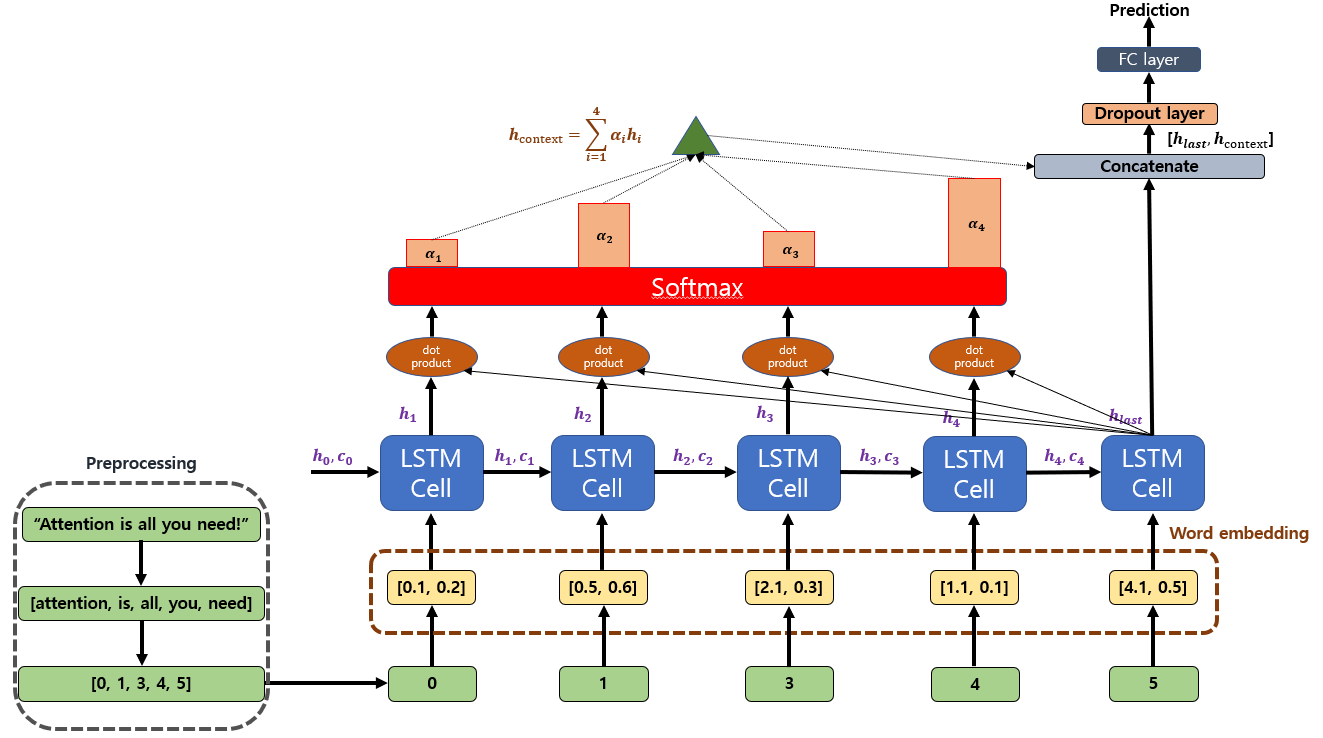

## **TODO** : Fill in the blanks of the codes to perform the above process and write your own description of the source code in your report.

In [21]:
# Make an lstm model with the attention mechanism that performs the above process.
# Note that batch-wise operation is performed. So check the shape of output at each stage.

# When implementing the attention mechanism, it is recommended to use broadcasting (the for loops may not be used). See https://numpy.org/doc/stable/user/basics.broadcasting.html for the details of broadcasting.
# If necessary, use unsqueeze() or squeeze() function to match the dimension for broadcasting.


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm

import pdb


class MyLSTM_att(nn.Module):
    def __init__(self, num_layers, hidden_size, n_vocab, embed_dim, num_classes, device, dropout_p=0.5):
        super(MyLSTM_att, self).__init__()


        self.hidden_size = hidden_size
        self.device = device
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.lstmcell =  MyLSTMCell(embed_dim, self.hidden_size)

        # fill in the blank --------------------------------------------------------------
        self.out =  nn.Linear(2*self.hidden_size, num_classes)    # This is the FC layer for final prediction in the above figure.
        # --------------------------------------------------------------------------------


    def forward(self, x):
        x = self.embed(x) # shape: (batch_size, sequence_length, embed_dim)
        h, c = self._init_state(batch_size=x.size(0)) # initialization
        hidden = []
        sequence_length = x.shape[1]

        # fill in the blank --------------------------------------------------------------
        '''
        You should add the following attention mechnism to the model in task 1 (refer to the above figure):
        1) The last hidden state is given as a query, and based on this, the similarities with the hidden states in the previous step are measured using dot-product.
        2) Using a softmax function, the results are normalized and attention scores (α) for each hidden state are obtained.
        3) Based on the attention scores (α) of each hidden state, we take a weighted average of hidden states (except for the last) and then, obtain a context vector.
        4) The context vector is concatenated with the last hidden state and prediction is performed based on it.
        '''

        for i in range(sequence_length):
          h, c = self.lstmcell(x[:, i, :], (h, c))
          if i == 0:
            hidden_h = h.unsqueeze(0)
          else:
            if i!=sequence_length:
                hidden_h = torch.cat((hidden_h, h.unsqueeze(0)))


        # for 1)
        scores = h * hidden_h

        # for 2)

        alpha = nn.Softmax(dim=-1)(scores)

        # for 3)
        context_2 = hidden_h*alpha
        context = torch.sum(context_2, dim=0)

        # for 4)

        out = self.out(self.dropout(torch.cat((h, context), dim=1)))


        # --------------------------------------------------------------------------------

        return out #shape: (batch size, number of classes)

    def _init_state(self, batch_size=1):
        h = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        c = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        return h, c

#### **Parameter settings for training**

In [22]:
lr = 0.001
epochs = 5  # If you increase the number of epochs, you can see the higher performance.
criterion = nn.CrossEntropyLoss()

#Set random seed for reproduction
random.seed(2023)
np.random.seed(2023)
torch.manual_seed(2023)

model = MyLSTM_att(1, 256, vocab_size, 128, num_classes, device, 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## **Training and Evaulation**

## **TODO** : Attach the training and evaluation results in your report.

In [23]:
#Model training
best_val_loss = None



for e in tqdm(range(1, epochs+1)):
    train(model, optimizer, train_iter, device, criterion )
    val_loss, val_accuracy = evaluate(model, val_iter, device, criterion)

    print("[Epoch: %d] val accuracy : %5.2f" % (e, val_accuracy))

    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("best_lstm_model_with_attention"):
            os.makedirs("best_lstm_model_with_attention")
        torch.save(model.state_dict(), './best_lstm_model_with_attention/best_model.pt')
        best_val_loss = val_loss

 20%|██        | 1/5 [01:33<06:12, 93.24s/it]

[Epoch: 1] val accuracy : 78.52


 40%|████      | 2/5 [03:06<04:39, 93.00s/it]

[Epoch: 2] val accuracy : 83.92


 60%|██████    | 3/5 [04:37<03:04, 92.22s/it]

[Epoch: 3] val accuracy : 85.23


 80%|████████  | 4/5 [06:08<01:31, 91.95s/it]

[Epoch: 4] val accuracy : 85.73


100%|██████████| 5/5 [07:38<00:00, 91.61s/it]

[Epoch: 5] val accuracy : 85.60


In [24]:
#Model evaluation
model.load_state_dict(torch.load('./best_lstm_model_with_attention/best_model.pt'))
test_loss, test_acc = evaluate(model, test_iter, device, criterion)
print('test loss: %5.2f | text accuracy: %5.2f' % (test_loss, test_acc))

test loss:  0.01 | text accuracy: 84.50


## **Check the result with a test sample**

In [25]:
import numpy as np

# Bring a sample from test dataset
test_example = vars(test_data[16])
print('Test example: ', test_example['text'])

Test example:  ['the', 'movie', 'is', 'okay.', 'meaning', 'that', 'i', "don't", 'regret', 'watching', 'it!', 'i', 'found', 'the', 'acting', 'purely', 'and', 'the', 'most', 'of', 'the', 'dialog', 'stupid', '("oh', 'no,', 'this', 'was', 'my', 'grandmothers', 'bible!").', "it's", 'sort', 'of', 'bad', 'remake', 'of', 'u-turn.', 'a', 'man', 'arrives', 'to', 'a', 'desert', 'town', 'out', 'in', 'nowhere,', 'meets', 'the', 'wrong', 'people', 'and', 'falls', 'in', 'love', 'with', 'the', 'wrong', 'woman.', 'and', 'off', 'cause', "get's", 'involved', 'in', 'something,', 'he', 'thought', 'he', 'could', 'leave', 'behind', 'him.', 'the', 'movie', 'is', 'quite', 'predictable', 'and', 'there', 'is', 'really', 'nothing', 'new', 'in', 'it.', 'when', "it's", 'finish,', 'you', "didn't", 'really', 'care.', 'most', 'of', 'the', 'characters', 'are', 'stereotypes,', 'specially', 'brian', 'austin', 'green!!', 'all', 'in', 'all', 'just', 'another', 'movie', 'from', 'the', 'states,', 'but', 'okay', 'entertaining

## **TODO** : Attach the results in your report.

In [26]:
# Check the result with a test sample using our trained model

index_vector = []

for text in test_example['text']:
    index_vector.append(TEXT.vocab.stoi[text])

index_vector_numpy = np.array(index_vector)
index_vector_tensor = torch.from_numpy(index_vector_numpy)
index_vector_tensor = index_vector_tensor.view(1,index_vector_tensor.size(0))

prediction = model(index_vector_tensor.to(device)).max(1)[1].item() # make a prediction through our trained model
prediction = 'Positive review' if prediction==1 else 'Negative review'
Ground_truth = 'Positive review' if test_example['label']==1 else 'Negative review'

# Compare the result with groundtruth
print('The prediction of our trained model on the test example:', prediction)
print('The true label of the test example:', Ground_truth)

The prediction of our trained model on the test example: Negative review
The true label of the test example: Negative review


## **TODO** : Describe the advantages of using the attention mechanism in the above task.

---------------------------------------------------------

# **Part 2. CycleGAN implementation using PyTorch**


## **What is CycleGAN?**

As we know, the key idea of **Generative Adversarial Networks (GANs)** is an *adversarial loss* that forces the generated fake images to be indistinguishable from real images. Also, GANs have achieved impressive results in Image-to-Image Translation tasks that converts an image from one
representation of a given scene, x, to another, y, e.g.,
grayscale to color, image to semantic labels, edge-map to
photograph.

However, these tasks have one practical problem that **obtaining paired training data can be difficult and expensive**(Figure 2(left)). For many tasks, like object transfiguration, the desired output is not even well-defined. Therefore, some methods that can learn to **translate between domains without paired input-output examples** are needed in Image-to-Image Translation tasks.

In the **CycleGan**, they present a method that can learn to do the
same: capturing special characteristics of one image collection
and figuring out how these characteristics could be
translated into the other image collection, all in the absence
of any paired training examples(Figure 2(right)) [1]. In particular, they exploit the property that translation should be **“cycle consistent”**, in the sense that if we translate,
e.g., a sentence from English to French, and then translate
it back from French to English, we should arrive back
at the original sentence. Their objective can be achieve by combining **cycle consistency loss with adversarial losses** on domains X and Y.

If you want to get more detailed information, please refer to the paper "*Unpaired image-to-image translation using cycle-consistent adversarial networks*" [1]. ([paper link](https://openaccess.thecvf.com/content_iccv_2017/html/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.html))

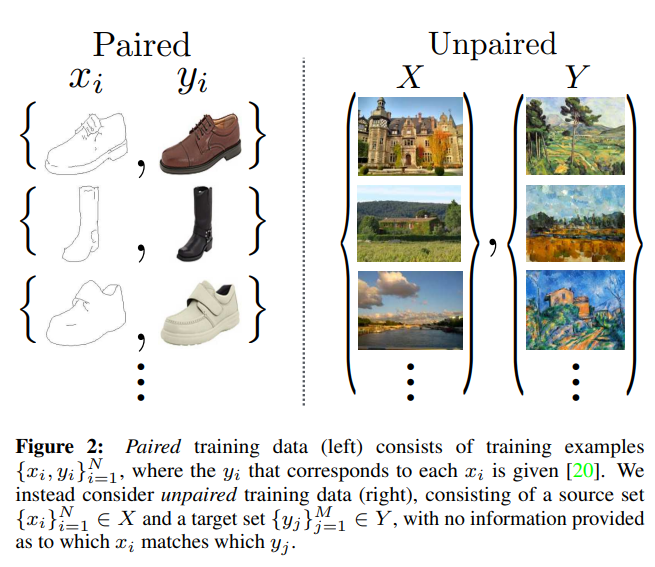

### **CycleGAN Formulation**
In this section, we formulate the CycleGAN based on the original paper [1]. As illustrated in Figure 3 (a), the model contains two mapping functions $G$ and $F$, and associated adversarial discriminators ${D_Y}$ and ${D_X}$ where
${D_X}$ aims to distinguish between real images from ${X}$ and translated
images ${F(Y)}$; in the same way, ${D_Y}$ aims to discriminate
between real images from ${Y}$ and ${G(X)}$. Here, ${X}$ and ${Y}$ represent two given domains.

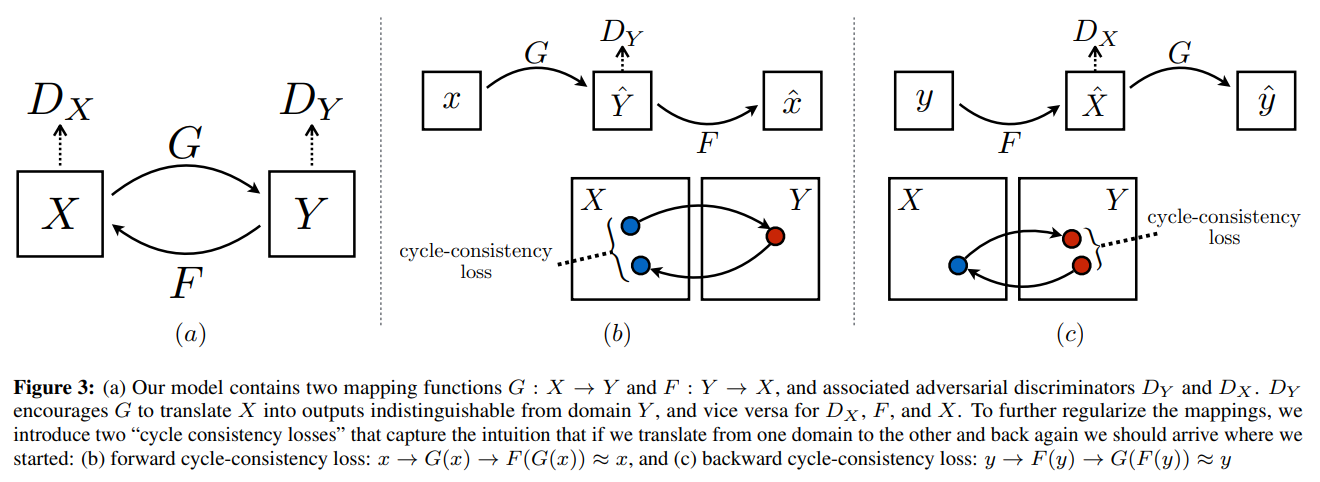

### **1) Adversarial Loss**

Mapping $G : X \to Y$

${L_{GAN}(G, D_Y, X, Y)} = \mathop{\mathbb{E}}_{y \sim p_{data}(y)}[\log D_{Y}(y)] + \mathop{\mathbb{E}}_{x \sim p_{data}(x)}[\log(1-
 D_{Y}(G(x)))] \tag{1} $

One of the loss functions is an *adversarial loss* for matching the distribution
of generated images to the data distribution in the target domain. First, for the mapping function $G : X \to Y$ and its discriminator
$D_Y$ , we can express the objective as equation (1) where $G$ tries to generate images $G(x)$ that look similar to
images from domain $Y$ , while $D_Y$ aims to distinguish between
translated samples $G(x)$ and real samples $y$. $G$ aims
to minimize this objective while discriminator $D$ tries to maximize it(equation (2)).

$\min_{G}\max_{D_Y}L_{GAN}(G, D_Y, X, Y) \tag{2} $

Similary, we can derive an adversarial loss for the mapping function $F : Y \to X$ and its discriminator $D_X$ like below equation (3) & (4).

Mapping $F : Y \to X$

${L_{GAN}(F, D_X, Y, X)} = \mathop{\mathbb{E}}_{x \sim p_{data}(x)}[\log D_{X}(x)] + \mathop{\mathbb{E}}_{y \sim p_{data}(y)}[\log(1-
D_{X}(F(y)))] \tag{3} $

$\min_{F}\max_{D_X}L_{GAN}(F, D_X, Y, X) \tag{4} $



### **2) Cycle Consistency Loss**
The other term is a *cycle consistency loss* to prevent the learned mappings $G$ and $F$ from contradicting each other. In other words, the learned mapping functions should be cycle-consistent: **Forward cycle consistency & Backward cycle consistency**

1. **Forward cycle consistency**: As shown in Figure 3 (b), for each image $x$ from domain $X$, the image translation cycle should be able to bring $x$ back to the original image, i.e., $x \to G(x) \to F(G(x)) \to x$.
2. **Backward cycle consistency**: Similary, as shown in Figure 3 (c), for
each image y from domain Y , G and F should also satisfy backward cycle consistency: $y \to F(y) \to G(F(y)) \to y$.

Finally, we can derive a *cycle consistency loss* like equation (5) below and the behavior induced by the cycle consistency loss can be observed in Figure 4.

${L_{cyc}(G, F)} = \mathop{\mathbb{E}}_{x \sim p_{data}(x)}[\|F(G(x))-x \|_1] + \mathop{\mathbb{E}}_{y \sim p_{data}(y)}[\|G(F(y))-y \|_1] \tag{5}$


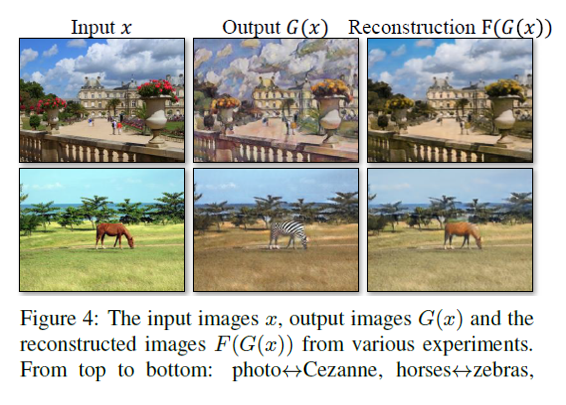

### **3) Full objective**
Finally, the full objective is:

$ L(G, F, D_X, D_Y) = L_{GAN}(G, D_Y, X, Y) + L_{GAN}(F, D_X, Y, X) + \lambda L_{cyc}(G, F), \tag{6} $

where $\lambda$ controls the relative importance of the two objectives.
And the solution we aim to optimize is:

$ G^*, F^* = \arg \min_{G, F} \max_{D_X, D_Y} L(G, F, D_X, D_Y) \tag{7} $


---

## **CycleGAN Implementation using Pytorch**
In this section, we will **implement CycleGAN using Pytorch with MNIST and SVHN(Street View House Numbers) datasets**. Similar to MNIST dataset, the SVHN is a digit classification benchmark dataset that contains 600000 32×32 RGB images of printed digits (from 0 to 9) cropped from pictures of house number plates. Each dataset represents different domains and our goal is to translate between these two domains(see Figure below).







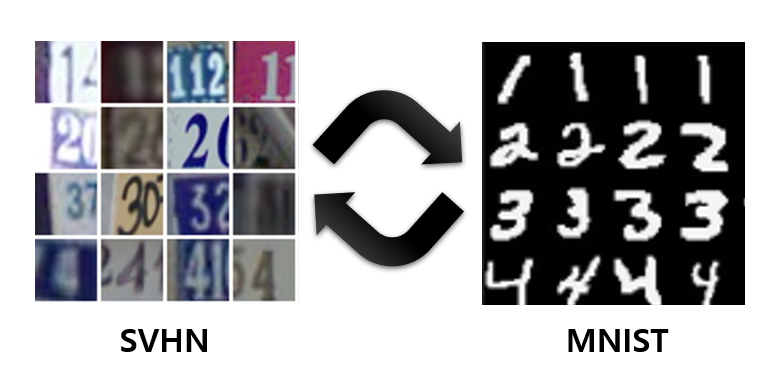

## **1. Data loading**



> Load the necessary modules & Set random seed for reproduction





In [27]:
import os
from torch.backends import cudnn
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torch import optim
from torchvision import datasets
from torchvision import transforms
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [28]:
random_seed = 200
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)



> Set hyper-parameters & Create directories if not exist.



In [29]:
# model hyper-parameters
image_size=32
g_conv_dim=64
d_conv_dim=64
use_labels=True
num_classes=10

# training hyper-parameters
train_iters=1000
batch_size=64
num_workers=2

# misc
mode='train'
model_path='./models'
sample_path='./samples'
mnist_path='./mnist'
svhn_path='./svhn'
download=True

In [30]:
# create directories if not exist
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(sample_path):
    os.makedirs(sample_path)



> Define `get_loader()` function to transform data and build dataloader for MNIST and SVHN dataset, respectively. And then, we can make each dataloader iterable using `iter()` so that it can be used for train and test phase.



In [31]:
def get_loader():
    """Builds and returns Dataloader for MNIST and SVHN dataset."""

    transform_mnist = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))])
    transform_svhn = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    svhn = datasets.SVHN(root=svhn_path, download=download, transform=transform_svhn)
    mnist = datasets.MNIST(root=mnist_path, download=download, transform=transform_mnist)

    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)
    return svhn_loader, mnist_loader

In [32]:
svhn_loader, mnist_loader = get_loader()
svhn_iter = iter(svhn_loader)
mnist_iter = iter(mnist_loader)
iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

# fixed mnist and svhn for sampling

pretty_svhn = [0,1,8,9,12,13,20,21,
        24,25,26,27,28,29,34,35,38,39,
        43,49,50,54,55,58,59,65,66,68,
        69,70,71,74,80,83,84,87,88,89,
        90,91,95,96,97,98,99,102,103,104,
        105,106,107,108,109,110,111,112,113,114,
        115,127,128,129,133,134]
fixed_svhn = torch.tensor(svhn_loader.dataset.data[pretty_svhn]).float().cuda()
fixed_svhn = ((fixed_svhn - fixed_svhn.min()) / (fixed_svhn.max() - fixed_svhn.min()) - 0.5)*2
next(mnist_iter)
fixed_mnist = next(mnist_iter)[0].cuda()
mnist_iter = iter(mnist_loader)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## **2. Define generator and discriminator**

- First, let's make the following residual block that will be used as an element of the generator.

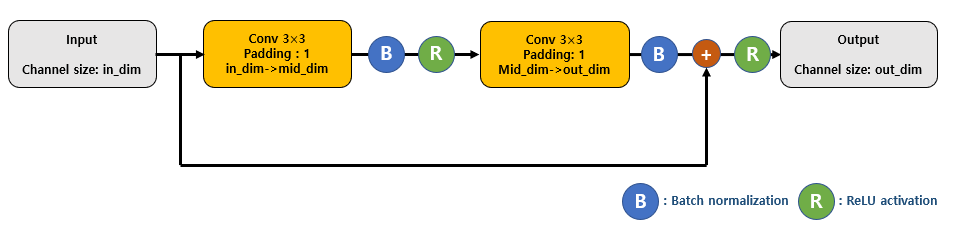

## **TODO**: Fill in the blanks of the codes below and write your own description of the source code in your report.

In [33]:
class Residual_Block(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim):
        super(Residual_Block, self).__init__()
        ### Fill in the blank --------------------------------------


        self.conv1 = nn.Conv2d(in_dim, mid_dim, kernel_size=3, padding = 1)
        self.bn1 = nn.BatchNorm2d(mid_dim)
        self.conv2 = nn.Conv2d(mid_dim, out_dim, kernel_size=3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_dim)


        ### --------------------------------------------------------


    def forward(self, x):
        ### Fill in the blank --------------------------------------

        x2 = F.relu(self.bn1(self.conv1(x)))
        x3 = x + self.bn2(self.conv2(x2))

        out = F.relu(x3)

        ### --------------------------------------------------------
        return out

- Based on residual block defined above, make a `Generator` class.

In [34]:
class Generator(nn.Module):
    def __init__(self, type, conv_dim=64):
        super(Generator, self).__init__()
        if type == 'mnist_to_svhn':
            in_dim, out_dim = 1, 3
        elif type == 'svhn_to_mnist':
            in_dim, out_dim = 3, 1
        # encoding blocks
        self.conv1 = nn.Conv2d(in_dim, conv_dim, kernel_size=3, padding = 1)
        self.bn1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, kernel_size=3, padding = 1)
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        # residual blocks
        self.res1 = Residual_Block(conv_dim*2, conv_dim, conv_dim*2)
        self.res2 = Residual_Block(conv_dim*2, conv_dim, conv_dim*2)
        # decoding blocks
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim, kernel_size=3, padding = 1)
        self.bn3 = nn.BatchNorm2d(conv_dim)
        self.conv4 = nn.Conv2d(conv_dim, out_dim, kernel_size=3, padding = 1)
        # other layers
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.downsample = nn.MaxPool2d(kernel_size=3, padding=1, stride = 2)
        self.upsample = nn.Upsample(scale_factor = 2, mode='bilinear')

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.downsample(out)
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.downsample(out)
        out = self.res1(out)
        out = self.res2(out)
        out = self.upsample(out)
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.upsample(out)
        out = self.tanh(self.conv4(out))
        return out

- Next, make a `Discriminator` class which has a total of 11 classes (classes 0 through 9 are for real images and class 10 is for fake images).

In [35]:
class Discriminator(nn.Module):
    def __init__(self, type, conv_dim=64):
        super(Discriminator, self).__init__()
        if type == 'mnist':
            in_dim = 1
        elif type == 'svhn':
            in_dim = 3
        # in_dim, out_dim = 1, 1

        # learnable layers
        self.conv1 = nn.Conv2d(in_dim, conv_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_dim * 2)
        self.conv3 = nn.Conv2d(conv_dim * 2, conv_dim * 2, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv_dim * 2)
        self.conv4 = nn.Conv2d(conv_dim * 2, conv_dim * 2, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(conv_dim * 2)


        self.fc = nn.Linear(conv_dim * 2, 11) # Note that classes 0 through 9 are for real images and class 10 is for fake images.

        # other functions
        self.relu = nn.ReLU()
        self.downsample = nn.MaxPool2d(kernel_size=3, padding= 1, stride=2)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.downsample(out)
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.downsample(out)
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.downsample(out)
        out = self.relu(self.bn4(self.conv4(out)))
        out = out.flatten(2,3).max(-1)[0]
        out = self.fc(out)
        return out

> Define the `optimize_model` function for optimizing networks

In [36]:
def optimize_model(optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



> Next, we define some auxiliary functions that can be used to merge images, show log and save images: `merge_images()`, `show_log()`, `save_img()`.



In [37]:
def merge_images(sources, targets):
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row * h, row * w * 2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i * h:(i + 1) * h, (j * 2) * h:(j * 2 + 1) * h] = s
        merged[:, i * h:(i + 1) * h, (j * 2 + 1) * h:(j * 2 + 2) * h] = t
    return merged.transpose(1, 2, 0)

In [38]:
def show_log(step, train_iters, D_ms_losses, D_sm_losses, G_msm_losses, G_ses_losses):
    D_ms_avg = np.array(D_ms_losses).mean()
    D_sm_avg = np.array(D_sm_losses).mean()
    G_msm_avg = np.array(G_msm_losses).mean()
    G_sms_avg = np.array(G_ses_losses).mean()

    print('Step [%d/%d], D_ms_loss: %.4f, D_sm_loss: %.4f, G_msm_loss: %.4f, G_sms_loss: %.4f'
    % (step + 1, train_iters, D_ms_avg, D_sm_avg, G_msm_avg, G_sms_avg))

In [39]:
def save_img(step, fixed_mnist, fixed_svhn, G, F, m_data, s_data, sample_path):
    fake_svhn = G(fixed_mnist)
    fake_mnist = F(fixed_svhn)

    mnist, fake_mnist = fixed_mnist.detach().cpu().numpy(), fake_mnist.detach().cpu().numpy()
    svhn, fake_svhn = fixed_svhn.detach().cpu().numpy(), fake_svhn.detach().cpu().numpy()

    merged = merge_images(mnist, fake_svhn)
    merged = np.interp(merged, (-1, 1), (0, 255))
    path = os.path.join(sample_path, 'sample-%d-m-s.png' % (step + 1))
    cv2.imwrite(path, merged)
    print('saved %s' % path)

    merged = merge_images(svhn, fake_mnist)
    merged = np.interp(merged, (-1, 1), (0, 255))
    path = os.path.join(sample_path, 'sample-%d-s-m.png' % (step + 1))
    cv2.imwrite(path, merged)
    print('saved %s' % path)



> By using the functions we defined above, we can build two Generators($G, F$), two Discriminators($D_X, D_Y$) and optimizers. In this case, generator $G$ utilizes MNIST as source domain and SVHN as targer domain(and generator $F$, vice versa). And $D_X$ is a discriminator in the MNIST domain and $D_Y$ is a discriminator in the SVHN domain. Also, we take **Adam** as optimizer for both of generator and discriminator.



In [40]:
# Build models and their optimizers

#Generator
G = Generator(conv_dim=64, type = 'mnist_to_svhn').cuda()
F = Generator(conv_dim=64, type = 'svhn_to_mnist').cuda()

#Discriminator
Dx = Discriminator(conv_dim=64, type = 'mnist').cuda()
Dy = Discriminator(conv_dim=64, type = 'svhn').cuda()

genParams = list(G.parameters()) + list(F.parameters())
disParams = list(Dx.parameters()) + list(Dy.parameters())

genOptimizer = optim.Adam(genParams)
disOptimizer = optim.Adam(disParams)

## **3. Train and evaluate CycleGAN**

## **TODO**: Fill in the blanks of the codes below and write your own description of the source code in your report.

### **Instruction**


> Fill in the blanks of 4 functions including `def Train_D_ms()`, `def Train_D_sm()`, `def Train_G_msm()`, `def Train_F_sms()`. Here, for example, `def Train_D_ms()` is for training discriminators in **m**nist-**s**vhn cycle where the source $X$ is MNIST and the target $Y$ is SVHN dataset. And, `def Train_G_msm()` is for training generator G in **m**nist-**s**vhn-**m**nist cycle.






### **Train discriminators (Dx, Dy)**



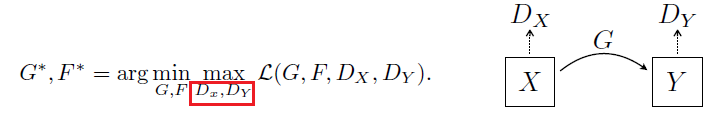

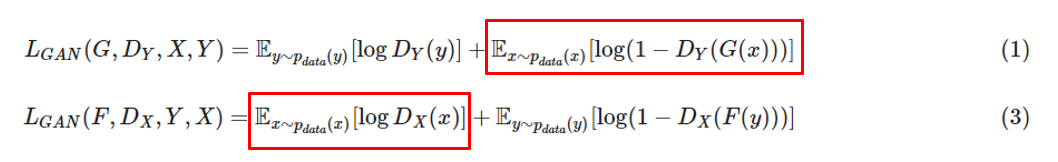


In [41]:
def Train_D_ms(Dx, Dy, G, m_data, m_label):
    '''
    # parameter:
    Dx, Dy: Discriminator for source domain(X, MNIST) and target domain(Y, SVHN), respectively.
    G: Generator which transfers X to Y
    m_data: source domain data (i.e., MNIST real images)
    m_label: source domain label (from 0 to 9)

    Train two discriminators(Dx, Dy) in mnist-svhn cycle.
    Please refer to the above figure that represents the path from X to Y and equation (1),(3).
    Unlike the conventional GAN, here, the discriminator classifies 11 classes. You have to use 1) the original labels(from 0 to 9) when training the discriminator with real images, and 2) the fake label(10) when training the discriminator with fake(generated) images. You should make the fake label for training.
    So, "torch.nn.functional.cross_entropy()" will be used for calculating losses.


    Return:
    D_ms_loss.item(): item of the loss
    '''

    # train mnist-svhn cycle

    # 1) Compute the loss of Dx (Dx_loss) with real images
    ### Fill in the blank --------------------------------------
    Dx_loss = nn.functional.cross_entropy(Dx(m_data), m_label)

    ### --------------------------------------------------------

    # 2) Compute the loss of Dy (Dy_loss) with fake images
    ### Fill in the blank --------------------------------------
    fake_label = m_label + 10
    fake_label = fake_label - m_label

    fake_image = G(m_data)

    Dy_loss = nn.functional.cross_entropy(Dy(fake_image), fake_label)



    ### --------------------------------------------------------

    D_ms_loss = Dx_loss + Dy_loss
    optimize_model(disOptimizer, D_ms_loss)
    return D_ms_loss.item()

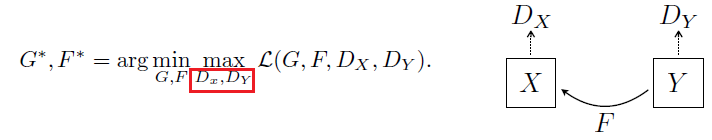

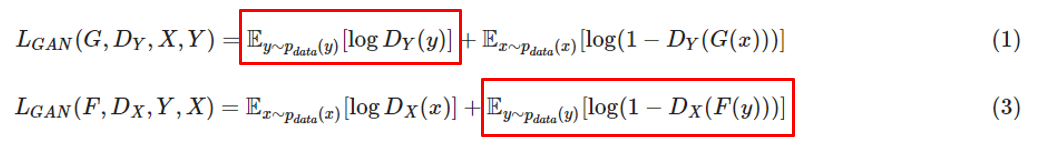

In [42]:
def Train_D_sm(Dx, Dy, F, s_data, s_label):
    '''
    # parameter:
    Dx, Dy: Discriminator for source domain(X, MNIST) and target domain(Y, SVHN), respectively.
    F: Generator which transfers Y to X
    s_data: target domain data (i.e., SVHN real images)
    s_label: target domain label (from 0 to 9)

    Train discriminators in svhn-mnist cycle.
    Please refer to the above figure that represents the path from Y to X and equation (1),(3).
    Unlike the conventional GAN, here, the discriminator classifies 11 classes. You have to use 1) the original labels(from 0 to 9) when training the discriminator with real images, and 2) the fake label(10) when training the discriminator with fake(generated) images. You should make the fake label for training.
    So, "torch.nn.functional.cross_entropy()" will be used for calculating losses.

    Return:
    D_sm_loss.item(): item of the loss
    '''

    # train svhn-mnist cycle

    # 1) Compute the loss of Dy (Dy_loss) with real images
    ### Fill in the blank --------------------------------------

    Dy_loss = nn.functional.cross_entropy(Dy(s_data), s_label)

    ### --------------------------------------------------------

    # 2) Compute the loss of Dx (Dx_loss) with fake images
    ### Fill in the blank --------------------------------------

    fake_label = s_label + 10
    fake_label = fake_label - s_label

    fake_image = F(s_data)

    Dx_loss = nn.functional.cross_entropy(Dx(fake_image), fake_label)

    ### --------------------------------------------------------

    D_sm_loss = Dx_loss + Dy_loss
    optimize_model(disOptimizer, D_sm_loss)
    return D_sm_loss.item()

### **Train generators (G, F) with cycle consistency loss**

> **1) Train the generator G**

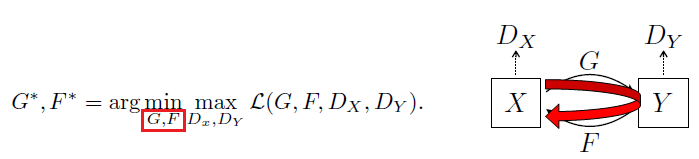

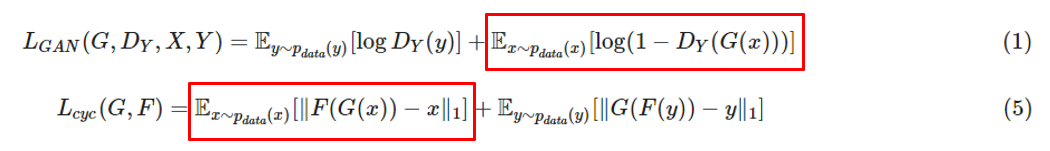

Note that, instead of L1 loss in equation (5), please use mean squared error loss $ \mathop{\mathbb{E}}_{x \sim p_{data}(x)}(F(G(x))-x)^2 $.

In [43]:
# train mnist-svhn-mnist cycle
def Train_G_msm(Dy, G, F, m_data, m_label):
    '''
    # parameter:
    Dy: Discriminator for target domain(Y, SVHN).
    G, F: Generator for X to Y and Y to X.
    m_data: source domain data (i.e., MNIST real images)
    m_label: source domain label (from 0 to 9)

    Train mnist-svhn-mnist cycle.
    Please refer to the above figure that represents the path from X to Y to X and equation (1),(5).
    Note that you have to use original labels(from 0 to 9) when training the generator.
    So, "torch.nn.functional.cross_entropy()" will be used for calculating losses.
    Also, this function has to include cycle consistency loss(i.e. Lcyc) with mean squared error loss.

    Return:
    G_msm_loss.item(): item of the loss
    '''

    # Compute the generator G loss (G_loss) with fake images
    ### Fill in the blank --------------------------------------

    fake_image = G(m_data)

    G_loss = nn.functional.cross_entropy(Dy(fake_image), m_label)



    ### --------------------------------------------------------

    # Compute the cycle consistency loss (Lcyc)
    ### Fill in the blank --------------------------------------

    Lcyc = nn.functional.mse_loss(F(fake_image), m_data)

    ### --------------------------------------------------------

    G_msm_loss = G_loss + 100 * Lcyc
    optimize_model(genOptimizer, G_msm_loss)
    return G_msm_loss.item()

> **2) Train the generator F**

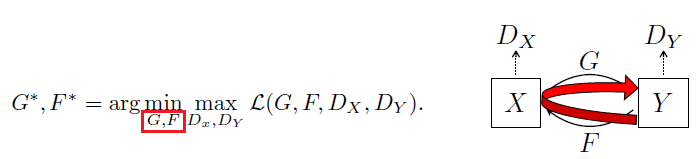

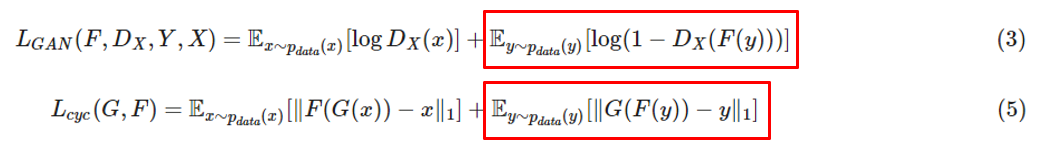

Note that, instead of L1 loss in equation (5), please use mean squared error loss $ \mathop{\mathbb{E}}_{y \sim p_{data}(y)}(G(F(y))-y)^2 $.

In [44]:
# train svhn-mnist-svhn cycle
def Train_G_sms(Dx, G, F, s_data, s_label):
    '''
    # parameter:
    Dx: Discriminator for source domain(X, MNIST).
    G, F: Generator for X to Y and Y to X.
    s_data: target domain data (i.e., SVHN real images)
    s_label: target domain label (from 0 to 9)

    Train svhn-mnist-svhn cycle.
    Please refer to the above figure that represents the path from Y to X to Y and equation (3),(5).
    Note that you have to use original labels(from 0 to 9) when training the generator.
    So, "torch.nn.functional.cross_entropy()" will be used for calculating losses.
    Also, this function has to include cycle consistency loss(i.e. Lcyc) with mean squared error loss.

    Return:
    G_sms_loss.item(): item of the loss
    '''

    # Compute the generator F loss (F_loss) with fake images
    ### Fill in the blank --------------------------------------

    fake_image = F(s_data)

    F_loss = nn.functional.cross_entropy(Dx(fake_image), m_label)


    ### --------------------------------------------------------

    # Compute the cycle consistency loss (Lcyc)
    ### Fill in the blank --------------------------------------

    Lcyc = nn.functional.mse_loss(G(fake_image), s_data)

    ### --------------------------------------------------------

    G_sms_loss = F_loss + 100 * Lcyc
    optimize_model(genOptimizer, G_sms_loss)
    return G_sms_loss.item()

> If you have filled in all the blanks, try to train and check the results.

## **TODO** : Attach the training and evaluation results in your report.

In [45]:
D_ms_losses, D_sm_losses, G_msm_losses, G_sms_losses = [], [], [], []

for step in range(train_iters + 1):
    # reset data_iter for each epoch
    if (step + 1) % iter_per_epoch == 0:
        mnist_iter = iter(mnist_loader)
        svhn_iter = iter(svhn_loader)

    # load svhn and mnist dataset
    s_data, s_label = next(svhn_iter)
    s_data, s_label = s_data.cuda(), s_label.cuda().long().squeeze()
    m_data, m_label = next(mnist_iter)
    m_data, m_label = m_data.cuda(), m_label.cuda()

    D_ms_losses.append(Train_D_ms(Dx, Dy, G, m_data, m_label))
    D_sm_losses.append(Train_D_sm(Dx, Dy, F, s_data, s_label))
    G_msm_losses.append(Train_G_msm(Dy, G, F, m_data, m_label))
    G_sms_losses.append(Train_G_sms(Dx, G, F, s_data, s_label))

    # print the log info
    if (step + 1) % 100 == 0:
        show_log(step, train_iters, D_ms_losses, D_sm_losses, G_msm_losses, G_sms_losses)

    # save the sampled images
    if (step + 1) == 1000:
        save_img(step, fixed_mnist, fixed_svhn, G, F, m_data, s_data, sample_path)

Step [100/1000], D_ms_loss: 0.6116, D_sm_loss: 2.1786, G_msm_loss: 16.6341, G_sms_loss: 12.3640
Step [200/1000], D_ms_loss: 0.4466, D_sm_loss: 1.7314, G_msm_loss: 13.2845, G_sms_loss: 12.3778
Step [300/1000], D_ms_loss: 0.4009, D_sm_loss: 1.5231, G_msm_loss: 11.7384, G_sms_loss: 12.7736
Step [400/1000], D_ms_loss: 0.3797, D_sm_loss: 1.3927, G_msm_loss: 10.8698, G_sms_loss: 13.1157
Step [500/1000], D_ms_loss: 0.3823, D_sm_loss: 1.3042, G_msm_loss: 10.3866, G_sms_loss: 13.2154
Step [600/1000], D_ms_loss: 0.3630, D_sm_loss: 1.2172, G_msm_loss: 10.0949, G_sms_loss: 13.3480
Step [700/1000], D_ms_loss: 0.3547, D_sm_loss: 1.1567, G_msm_loss: 9.9307, G_sms_loss: 13.3693
Step [800/1000], D_ms_loss: 0.3525, D_sm_loss: 1.1121, G_msm_loss: 9.8428, G_sms_loss: 13.4349
Step [900/1000], D_ms_loss: 0.3366, D_sm_loss: 1.0641, G_msm_loss: 9.7645, G_sms_loss: 13.6881
Step [1000/1000], D_ms_loss: 0.3229, D_sm_loss: 1.0229, G_msm_loss: 9.7766, G_sms_loss: 13.9650
saved ./samples/sample-1000-m-s.png
saved .

In [46]:
result_m_s = cv2.imread('samples/sample-1000-m-s.png')
result_s_m = cv2.imread('samples/sample-1000-s-m.png')

MNIST_to_SVHN


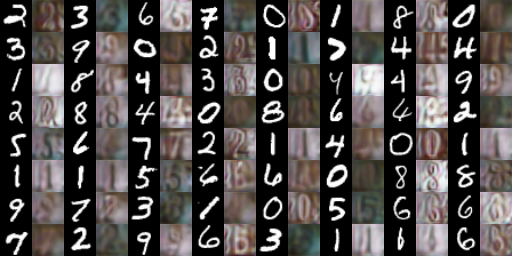

In [47]:
print('MNIST_to_SVHN')
cv2_imshow(result_m_s)

SVHN_to_MNIST


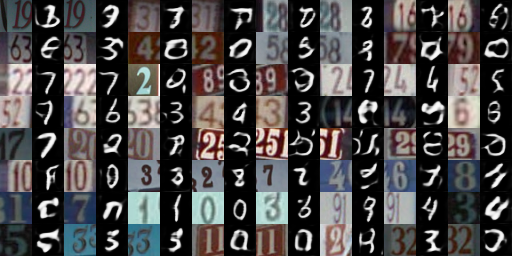

In [48]:
print('SVHN_to_MNIST')
cv2_imshow(result_s_m)

## **TODO** : If the discriminator classifies only two classes (whether real or fake) as in the conventional GAN, what problem will arise?

#**Reference**

(1) Part1: Implement LSTM model in word-level language modelling

https://towardsdatascience.com/nlp-preprocessing-with-nltk-3c04ee00edc0

https://wikidocs.net/60314

https://zzsza.github.io/data/2018/03/10/nlp-python/

https://i.stack.imgur.com/GmKNd.png

https://www.gousios.gr/courses/ml4se/2019/nn.html

https://torchtext.readthedocs.io/en/latest/data.html#fields

(2) Part 2: CycleGAN

"*Unpaired image-to-image translation using cycle-consistent adversarial networks*". ([paper link](https://openaccess.thecvf.com/content_iccv_2017/html/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.html))